## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.manifold import TSNE
import openTSNE

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("datasets/smoking_drinking_dataset.csv")
df.shape

(991346, 24)

In [3]:
df.head().transpose()

,0,1,2,3,4
sex,Male,Male,Male,Male,Male
age,35,30,40,50,50
height,170,180,165,175,165
weight,75,80,75,80,60
waistline,90.0,89.0,91.0,91.0,80.0
sight_left,1.0,0.9,1.2,1.5,1.0
sight_right,1.0,1.2,1.5,1.2,1.2
hear_left,1.0,1.0,1.0,1.0,1.0
hear_right,1.0,1.0,1.0,1.0,1.0
SBP,120.0,130.0,120.0,145.0,138.0


## Drop duplicates

In [4]:
df.drop_duplicates(inplace=True)

## Encode categorical features

In [5]:
le = LabelEncoder()
df["sex"] = le.fit_transform(df["sex"])
mappings = dict(zip(le.classes_, range(len(le.classes_))))
print("Label Mappings:", mappings)
df["hear_left"] = le.fit_transform(df["hear_left"])
mappings = dict(zip(le.classes_, range(len(le.classes_))))
print("Label Mappings:", mappings)
df["hear_right"] = le.fit_transform(df["hear_right"])
mappings = dict(zip(le.classes_, range(len(le.classes_))))
print("Label Mappings:", mappings)
df["urine_protein"] = le.fit_transform(df["urine_protein"])
mappings = dict(zip(le.classes_, range(len(le.classes_))))
print("Label Mappings:", mappings)
df["DRK_YN"] = le.fit_transform(df["DRK_YN"])
mappings = dict(zip(le.classes_, range(len(le.classes_))))
print("Label Mappings:", mappings)
df["SMK_stat_type_cd"] = le.fit_transform(df["SMK_stat_type_cd"])
mappings = dict(zip(le.classes_, range(len(le.classes_))))
print("Label Mappings:", mappings)

Label Mappings: {'Female': 0, 'Male': 1}
Label Mappings: {1.0: 0, 2.0: 1}
Label Mappings: {1.0: 0, 2.0: 1}
Label Mappings: {1.0: 0, 2.0: 1, 3.0: 2, 4.0: 3, 5.0: 4, 6.0: 5}
Label Mappings: {'N': 0, 'Y': 1}
Label Mappings: {1.0: 0, 2.0: 1, 3.0: 2}


## Change data type

In [6]:
for column in ["SMK_stat_type_cd", "urine_protein", "SBP", "DBP", "BLDS", "tot_chole", "HDL_chole", "LDL_chole", "triglyceride", "SGOT_AST", "SGOT_ALT", "gamma_GTP"]:
    df[column] = df[column].astype(int)

## Handle outliers

In [7]:
def get_means(males, females, features):
    means_males = dict()
    means_females = dict()

    for feature in features:
        means_males[feature] = males[feature].mean()
        means_females[feature] = females[feature].mean()
    
    return means_males, means_females

def detect_outliers(data, features, k):
    # data["outlier"] = 0

    males = data.loc[data["sex"] == 1]
    females = data.loc[data["sex"] == 0]
    print("Number of males:", len(males))
    print("Number of females:", len(females), "\n")

    # mean_males, mean_females = get_means(males, females, features)

    for feature in features:
        Q1_males = males[feature].quantile(0.25)
        Q1_females = females[feature].quantile(0.25)

        Q3_males = males[feature].quantile(0.75)
        Q3_females = females[feature].quantile(0.75)

        IQR_males = Q3_males - Q1_males
        IQR_females = Q3_females - Q1_females

        lower_bound_males = Q1_males - k * IQR_males
        lower_bound_females = Q1_females - k * IQR_females
        
        upper_bound_males = Q3_males + k * IQR_males
        upper_bound_females = Q3_females + k * IQR_females

        print("Males", feature, "lower:", lower_bound_males, "upper:", upper_bound_males)
        print("Females", feature, "lower:", lower_bound_females, "upper:", upper_bound_females)
        print()

        # males.loc[(males[feature] < lower_bound_males) | (males[feature] > upper_bound_males), "outlier"] = 1
        males.loc[males[feature] > upper_bound_males, feature] = upper_bound_males
        males.loc[males[feature] < lower_bound_males, feature] = lower_bound_males

        # females.loc[(females[feature] < lower_bound_females) | (females[feature] > upper_bound_females), "outlier"] = 1
        females.loc[females[feature] > upper_bound_females, feature] = upper_bound_females
        females.loc[females[feature] < lower_bound_females, feature] = lower_bound_females

    return pd.concat([males, females]).sort_index()

features = ["age","height","weight","waistline","sight_left","sight_right","SBP","DBP","BLDS","tot_chole","HDL_chole","LDL_chole","triglyceride","hemoglobin","serum_creatinine","SGOT_AST","SGOT_ALT","gamma_GTP"]

df = detect_outliers(df, features, 1.5)

# anomalies = data.loc[data["outlier"] == 1]
# normal = data.loc[data["outlier"] == 0]
# 
# print("Total:", len(normal) + len(anomalies))
# print("Anomalies:", len(anomalies))
# print("Normal: ", len(normal))
# print(f"Anomaly ratio: {len(anomalies) / (len(normal) + len(anomalies)):.2f}")

Number of males: 526399
Number of females: 464921 

Males age lower: 5.0 upper: 85.0
Females age lower: 10.0 upper: 90.0

Males height lower: 150.0 upper: 190.0
Females height lower: 135.0 upper: 175.0

Males weight lower: 50.0 upper: 90.0
Females weight lower: 35.0 upper: 75.0

Males waistline lower: 65.0 upper: 105.0
Females waistline lower: 50.5 upper: 102.5

Males sight_left lower: 0.20000000000000018 upper: 1.7999999999999998
Females sight_left lower: -0.050000000000000044 upper: 1.95

Males sight_right lower: 0.20000000000000018 upper: 1.7999999999999998
Females sight_right lower: 0.2499999999999999 upper: 1.4500000000000002

Males SBP lower: 90.5 upper: 158.5
Females SBP lower: 80.0 upper: 160.0

Males DBP lower: 49.0 upper: 105.0
Females DBP lower: 50.0 upper: 98.0

Males BLDS lower: 63.0 upper: 135.0
Females BLDS lower: 64.5 upper: 124.5

Males tot_chole lower: 94.0 upper: 294.0
Females tot_chole lower: 95.0 upper: 295.0

Males HDL_chole lower: 17.5 upper: 85.5
Females HDL_cho

In [83]:
# df["SMK_never"] = 0
# df["SMK_used_to"] = 0
# df["SMK_still"] = 0
# df.info()

In [84]:
# df.loc[df["SMK_stat_type_cd"] == 1, "SMK_never"] = 1
# df.loc[df["SMK_stat_type_cd"] == 2, "SMK_used_to"] = 1
# df.loc[df["SMK_stat_type_cd"] == 3, "SMK_still"] = 1
# df.drop(columns=["SMK_stat_type_cd"], inplace=True)

In [8]:
df.describe().round(1).transpose()

,count,mean,std,min,25%,50%,75%,max
sex,991320.0,0.5,0.5,0.0,0.0,1.0,1.0,1.0
age,991320.0,47.6,14.2,20.0,35.0,45.0,60.0,85.0
height,991320.0,162.2,9.3,135.0,155.0,160.0,170.0,190.0
weight,991320.0,63.1,11.9,35.0,55.0,60.0,70.0,90.0
waistline,991320.0,81.1,9.5,50.5,74.1,81.0,87.8,105.0
sight_left,991320.0,1.0,0.3,0.1,0.7,1.0,1.2,2.0
sight_right,991320.0,1.0,0.3,0.2,0.7,1.0,1.2,1.8
hear_left,991320.0,0.0,0.2,0.0,0.0,0.0,0.0,1.0
hear_right,991320.0,0.0,0.2,0.0,0.0,0.0,0.0,1.0
SBP,991320.0,122.3,14.1,80.0,112.0,120.0,131.0,160.0


## Correlation matrix

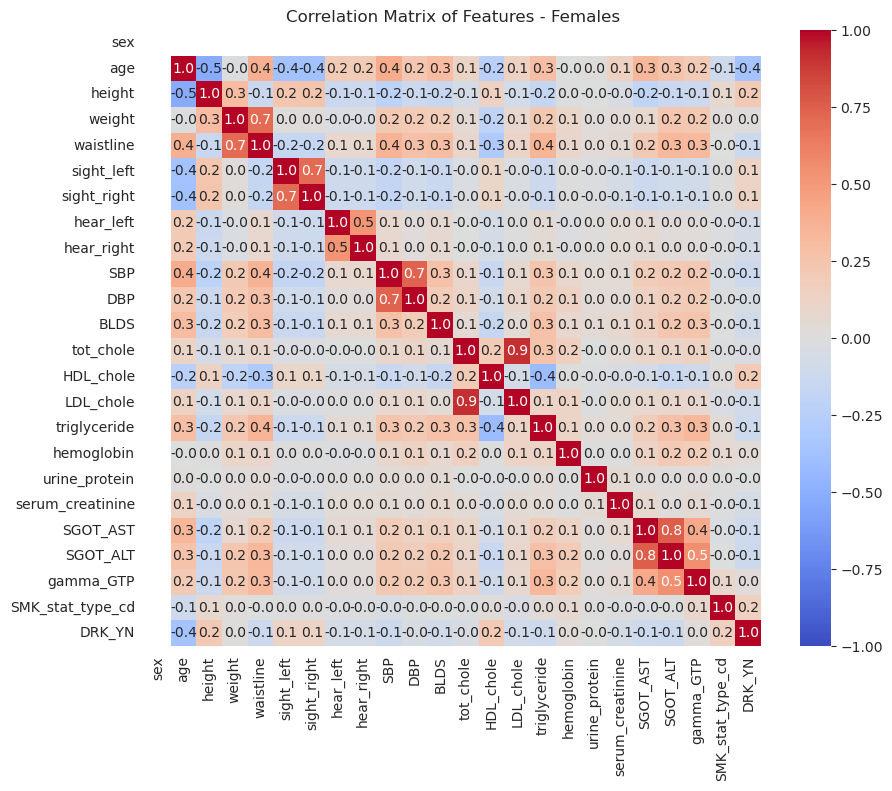

In [9]:
corr_matrix = df[df["sex"] == 0].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".1f", cmap="coolwarm", vmin=-1, vmax=1, square=True)
plt.title("Correlation Matrix of Features - Females")
plt.show()

## Saving dataset

In [12]:
df.to_csv("df_processed.csv", index=False)